# Проект: определение стоимости автомобилей

**Описание проекта:** Автомобиля уже долгие годы являются одним из самых необходимых, но самым дорогим вложением. В тоже время, на рынке автомобилей много обмана. Помочь может изучение информации из VIN-кодов. В данном проекте на основе лишь вин-кодов автомобилей создана модель машинного обучения предсказывающая цену автомобиля. <br>

**Цель исследования:** создать модели машинного обучения,позволяющей определить цену автомобиля по Vin коду.<br>

**Ход исследования:**
Для выполнения цели исследования необходимо будет выполнить следующие задачи:
- <u>Первоначальный анализ и предобработка данных.</u> Загрузка данных, первоначальное их изучение и анализ, их предобработка.
- <u>Исследовательский анализ данных.</u> исследование данных, их корреляция.
- <u>Обучние модели.</u> Создание модели машинного оучения, подбор гипперпараметров, анализ важности признаков.  
- <u>Вывод </u> Описание результатов исследования, выводы. Поле для анализа Вин-кода.

Данное исследование может стать основой для анализа стоимости автомобилей.

## Предобработка данных

Загрузим небоходмые библотеки

In [3]:
!pip install -U nbconvert

   ---------------------------------------- 0.0/257.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/257.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/257.4 kB ? eta -:--:--
   ------ -------------------------------- 41.0/257.4 kB 393.8 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/257.4 kB 655.4 kB/s eta 0:00:01
   ------------------------- ------------ 174.1/257.4 kB 952.6 kB/s eta 0:00:01
   ---------------------------------------  256.0/257.4 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 257.4/257.4 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 7.10.0
    Uninstalling nbconvert-7.10.0:
      Successfully uninstalled nbconvert-7.10.0


In [ ]:
import re
import string
import pandas as pd
import tqdm
import phik
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error,\
                            max_error, explained_variance_score,\
                            mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

Посмотрим на данные

In [ ]:
with open('all_models_train.txt', 'r') as f:
    file = f.read()

Создадим датафрейм из всего массива vin_кодов. В связи с тем, что цифры с 4 по 8 по разному используются разными приозводителями, данные цифры пока оставим отдельно, для будующей обработки.

In [ ]:
pattern = r'''\[
       (?P<country>.{2})
       (?P<mini_prod>.{1})
       (?P<number_4>.{1})
       (?P<number_5>.{1})
       (?P<number_6>.{1})
       (?P<number_7>.{1})
       (?P<number_8>.{1})
       (?P<control>.{1})
       (?P<year>.{1})
       (?P<factory_code>.{1})
       (?P<serial_namber>.{3}\d{3})
      :(?P<price>\d{1,6})\]
      '''
df_vin= pd.DataFrame.from_dict([(x.groupdict()) for x in re\
                                .compile(pattern, re.X).finditer(file)])
print(df_vin.shape)
df_vin.head()

(440236, 12)


,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price
0,2F,M,D,K,3,J,C,4,B,B,A41556,12500
1,3F,A,6,P,0,H,7,5,E,R,208976,14500
2,3N,1,A,B,6,A,P,4,C,L,698412,9100
3,5G,R,G,N,2,3,U,9,3,H,101360,13300
4,3F,A,H,P,0,8,Z,1,7,R,268380,1300


In [ ]:
df_vin['WMI'] = df_vin['country'] + df_vin['mini_prod']  #  вводим столбец с полным WMI

In [ ]:
df_vin.head()

,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price,WMI
0,2F,M,D,K,3,J,C,4,B,B,A41556,12500,2FM
1,3F,A,6,P,0,H,7,5,E,R,208976,14500,3FA
2,3N,1,A,B,6,A,P,4,C,L,698412,9100,3N1
3,5G,R,G,N,2,3,U,9,3,H,101360,13300,5GR
4,3F,A,H,P,0,8,Z,1,7,R,268380,1300,3FA


Первые две цифры - это код страны-изготовителя. Может быть восстановлен из справочника.

In [ ]:
country = pd.read_html('https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/World_Manufacturer_Identifier_(WMI)')

In [ ]:
country[0]  #таблица с соотношением буквенного обозначения и стран

,WMI,Region,Notes
0,A-C,Africa,AA-AH = South Africa BU = Uganda DF-DK = Morocco
1,J-R,Asia,J = Japan KF-KK = Israel KL-KR = South Korea L...
2,S-Z,Europe,SA-SM = United Kingdom SN-ST = Germany (former...
3,1-5,North America,"1, 4, 5 = United States 2 = Canada 3 = Mexico ..."
4,6-7,Oceania,6A-6W = Australia 7A-7E = New Zealand
5,8-9,South America,8A-8E = Argentina 8F-8J = Chile 8L-8R = Ecuado...


In [ ]:
symbols = string.ascii_uppercase.replace('I','').replace('O','').replace('Q','')\
          +string.digits.replace('0','')+'0'
symbols  #символы, используемые в кодах

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

Преобразуем таблицу из буквенного кода и стран в читаемый для программы вид.

In [ ]:
pattern_country = r'''(?P<cipher>(.{1,2}-?(.{1,2})?)|(.{7}),?\s?(.{1,2}-(.{1,2}))?)
             \s=\s(?P<country>([A-Z][a-z]{2,13})\s?([A-Z][a-z]{2,13})?\s?(\(.{2,30}\))?)'''

In [ ]:
country_df = pd.DataFrame(columns=['cipher','country','region'])
for i in range(6):
    text = country[0]['Notes'][i]
    df= pd.DataFrame.from_dict([(x.groupdict()) for x in re\
                                .compile(pattern_country, re.X).finditer(text)])
    df['region'] = country[0]['Region'][i]
    country_df = pd.concat([country_df, df])
country_df = country_df.reset_index(drop = True)
country_df.head()

,cipher,country,region
0,AA-AH,South Africa,Africa
1,BU,Uganda,Africa
2,DF-DK,Morocco,Africa
3,J,Japan,Asia
4,KF-KK,Israel,Asia


Преобразуем буквенное обозначение стран в список

In [ ]:
def cipher_new(s):
    if ('-' in s) and (len(s)<7):
        a = symbols.find(s[1])
        b = symbols.find(s[4])
        h = []
        for i in range(a,b+1):
            k = s[0]+symbols[i]
            h.append(k)
        return h
    else:
        return s

In [ ]:
country_df['cipher'] = country_df['cipher'].apply(lambda x: cipher_new(x))

In [ ]:
country_df['cipher'][59] = ['9A', '9B', '9C', '9D', '9E', '93', '94',\
                            '95', '96', '97', '98', '99']

In [ ]:
for i in range(len(country_df)):  # создание списка из короткого буквенного обозначения
    if len(country_df['cipher'][i])==1:
        a = []
        for k  in symbols:
            a.append(country_df['cipher'][i]+k)
        country_df['cipher'][i] = a

In [ ]:
a = []
for i in ['1', '4', '5']:
    for k in symbols:
        a.append(i+k)
country_df['cipher'][48] = a

In [ ]:
country_df['country'] = country_df['country'].apply(lambda x:x.strip())
country_df['region'] = country_df['region'].apply(lambda x:x.strip())

In [ ]:
country_df.head()  # таблица стран и регионов по первым двум цифрам vin-кода

,cipher,country,region
0,"[AA, AB, AC, AD, AE, AF, AG, AH]",South Africa,Africa
1,BU,Uganda,Africa
2,"[DF, DG, DH, DJ, DK]",Morocco,Africa
3,"[JA, JB, JC, JD, JE, JF, JG, JH, JJ, JK, JL, J...",Japan,Asia
4,"[KF, KG, KH, KJ, KK]",Israel,Asia


Посмотрим какие первые две цифры есть в датафрейме и на основе их создадим словарь для преобразования.

In [ ]:
u = df_vin['country'].unique()
u

array(['2F', '3F', '3N', '5G', '3L', '1G', '1F', 'KM', '5T', 'JN', '2G',
       '1H', '2H', '3G', 'YS', '2C', '5N', '4J', '4T', 'WV', 'JM', 'WB',
       '1N', '1Z', 'KN', 'SA', '4S', 'WD', '1C', '5X', 'JT', '1L', '9B',
       '2T', '1J', '19', 'ZF', 'KL', '3A', '1A', '3V', '2D', '2L', '1D',
       'YV', 'WA', 'JH', '5U', '1B', '3D', 'WM', '5Y', '1V', '5F', 'JA',
       '5J', '2A', '4A', '5L', '3C', 'WP', 'JF', '3H', '4F', '1Y', 'NM',
       'JS', '2B', 'W0', '3T', '4M', '1M', 'SC', 'ML', 'SH', '3M', '2M',
       '4U', '4C', 'YH', 'TR', '5S', '2S', '4N', '3B', 'ZA', 'WU', '2V',
       '55', '6G', '6M', '13', '4B', '4G', '5K', '1P', 'VN', 'ZH', '2P',
       '5B', '3P', '5Z', '2J'], dtype=object)

In [ ]:
country_dict = {}
for t in tqdm(range(1000)):
    for i in u:
        for k in range(len(country_df)):
            if i in country_df['cipher'][k]:
                country_dict[i] = country_df['country'][k]
print(len(country_dict))

100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]

103


Добавим страну изготовителя в датафрейм

In [ ]:
df_vin = df_vin.replace({'country':country_dict})

In [ ]:
df_vin.head()

,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price,WMI
0,Canada,M,D,K,3,J,C,4,B,B,A41556,12500,2FM
1,Mexico,A,6,P,0,H,7,5,E,R,208976,14500,3FA
2,Mexico,1,A,B,6,A,P,4,C,L,698412,9100,3N1
3,United States,R,G,N,2,3,U,9,3,H,101360,13300,5GR
4,Mexico,A,H,P,0,8,Z,1,7,R,268380,1300,3FA


Добавим регион в датафрейм

In [ ]:
u = df_vin['country'].unique()
u

array(['Canada', 'Mexico', 'United States', 'South Korea', 'Japan',
       'Sweden', 'Germany (formerly West Germany)', 'United Kingdom',
       'Brazil', 'Italy', 'Turkey', 'Thailand', 'Finland', 'Hungary',
       'Australia', 'France'], dtype=object)

In [ ]:
region_dict = {}
for t in tqdm(range(1000)):
    for i in u:
        for k in range(len(country_df)):
            if i in country_df['country'][k]:
                region_dict[i] = country_df['region'][k]
len(region_dict)


100%|██████████| 1000/1000 [00:07<00:00, 132.29it/s]


16

In [ ]:
df_vin['region'] = df_vin['country']
df_vin = df_vin.replace({'region':region_dict})

In [ ]:
df_vin.head()  # добавили регион изготовителя

,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price,WMI,region
0,Canada,M,D,K,3,J,C,4,B,B,A41556,12500,2FM,North America
1,Mexico,A,6,P,0,H,7,5,E,R,208976,14500,3FA,North America
2,Mexico,1,A,B,6,A,P,4,C,L,698412,9100,3N1,North America
3,United States,R,G,N,2,3,U,9,3,H,101360,13300,5GR,North America
4,Mexico,A,H,P,0,8,Z,1,7,R,268380,1300,3FA,North America


После добавления страны и региона, стоит добавить марку машины, где она известна.

In [ ]:
model_df = country[2]
model_df.head()

,WMI,Manufacturer
0,AAA,Audi South Africa made by Volkswagen of South ...
1,AAK,FAW Vehicle Manufacturers SA (PTY) Ltd.
2,AAM,MAN Automotive (South Africa) (Pty) Ltd. (incl...
3,AAP,VIN restamped by South African Police Service ...
4,AAV,Volkswagen South Africa


In [ ]:
model_df['WMI'][59] = ['JHF','JHG','JHL','JHM','JHN','JHZ','JH1','JH2',\
                       'JH3','JH4','JH5']

Возьмем самые распространенные автомобили.

In [ ]:
top_50 = pd.read_html('https://www.autostat.ru/analytics/31606/?ysclid=lvau4nt0eo563299267')

In [ ]:
marka_list = []
for i in range(1,51):
    marka_list.append(top_50[1][2][i])
print('Количество марок машин в топ-50:',len(marka_list))

Количество марок машин в топ-50: 50


In [ ]:
top_20 = pd.read_html('https://greenway.icnet.ru/cars-sales-actual-world.html?ysclid=lvauqz7j8c806784217#null')

In [ ]:
for i in range(1,21):
    marka_list.append(top_20[1][1][i])
print(len(marka_list))
marka_list.append('Chrysler')
marka_list.append('Pontiac')
marka_list.append('Infiniti')
marka_list.append('Lincoln')
marka_list.append('Jaguar')
marka_list = set(marka_list)
print('Окончательное количество марок:', len(marka_list))

70
Окончательное количество марок: 59


Выделяем марки машин путем добавления столбца в датафрейм

In [ ]:
def marka_new(name):
    for i in marka_list:
        if i in name:
            return i

In [ ]:
model_df['marka'] = model_df['Manufacturer'].apply(lambda x:marka_new(x))

In [ ]:
model_df.head(10)

,WMI,Manufacturer,marka
0,AAA,Audi South Africa made by Volkswagen of South ...,Volkswagen
1,AAK,FAW Vehicle Manufacturers SA (PTY) Ltd.,None
2,AAM,MAN Automotive (South Africa) (Pty) Ltd. (incl...,None
3,AAP,VIN restamped by South African Police Service ...,None
4,AAV,Volkswagen South Africa,Volkswagen
5,AAW,Challenger Trailers (South Africa),None
6,ABJ,Mitsubishi Colt & Triton pickups made by Merce...,Mitsubishi
7,ABJ,Mitsubishi Fuso made by Daimler Trucks & Buses...,Mitsubishi
8,ACV,Isuzu Motors South Africa 2018-,Isuzu
9,AC5,Hyundai Automotive South Africa,Hyundai


In [ ]:
model_df = model_df.dropna()
model_df = model_df.reset_index(drop=True)
len(model_df)  # окончательное количество марок

802

In [ ]:
u = df_vin['WMI'].unique()

In [ ]:
model_dict = {}
for t in tqdm(range(1000)):
    for i in u:
        for k in range(len(model_df)):
            if i in model_df['WMI'][k]:
                model_dict[i] = model_df['marka'][k]
len(model_dict)


100%|██████████| 1000/1000 [24:42<00:00,  1.48s/it]


251

In [ ]:
df_vin['model'] = df_vin['WMI']
df_vin = df_vin.replace({'model':model_dict})

In [ ]:
df_vin['model'] = df_vin['model'].replace(['4T1','4T2','4T3','4T4',\
                            '4T5','4T6','4T7','4T8','4T9','4T0'],'Toyota')

In [ ]:
df_vin.head()

,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price,WMI,region,model
0,Canada,M,D,K,3,J,C,4,B,B,A41556,12500,2FM,North America,Ford
1,Mexico,A,6,P,0,H,7,5,E,R,208976,14500,3FA,North America,Ford
2,Mexico,1,A,B,6,A,P,4,C,L,698412,9100,3N1,North America,Nissan
3,United States,R,G,N,2,3,U,9,3,H,101360,13300,5GR,North America,5GR
4,Mexico,A,H,P,0,8,Z,1,7,R,268380,1300,3FA,North America,Ford


In [ ]:
df_vin['model'].value_counts()[:10]

model
Ford         75299
Nissan       53069
Chevrolet    50183
Chrysler     36221
Toyota       33092
Honda        26657
Hyundai      23917
BMW          16633
Mercedes     13585
Dodge        12773
Name: count, dtype: int64

Обозначим редковстречаемые модели как other.

In [ ]:
df_vin['model'] = df_vin['model'].replace(['Jeep','5GR', 'YS3', '5GT',
       'WP0', '5GZ', '1G3', '4TA', 'W08',
       '4M2', '1ME', 'SCB', '3GS', '2B8', 'ML3', '3ME', '2ME', 'WP1',
       '2MR', '1ZW', 'YH4', '5S3', 'ZAM',  '137', 'SCA', 'ZFF',
       '2MH', '1P3', 'ZHW', '1B8', '3MA', '5GN', 'SCF', '2P4', '1P4',
       'WDY', '3P3', '2FD'],'Other')

Автомобили имеют разные характеристики на месте цифр 4-8. Если сводить к общим характеристикам, это будет система безопасности, тип двигателя и тип кузова   

In [ ]:
df_vin['model'].unique()

array(['Ford', 'Nissan', 'Other', 'Lincoln', 'Pontiac', 'Hyundai',
       'Toyota', 'Buick', 'Chevrolet', 'Honda', 'Cadillac', 'GMC',
       'Chrysler', 'Mercedes', 'Volkswagen', 'Mazda', 'BMW', 'Kia',
       'Jaguar', 'Subaru', 'Lexus', 'Fiat', 'Suzuki', 'Land Rover',
       'Dodge', 'Volvo', 'Audi', 'Infiniti', 'MINI', 'Mitsubishi', 'WME',
       'Isuzu', 'Tesla'], dtype=object)

In [ ]:
def safety(line):
    if (line=='Ford') or (line=='Chrysler') or (line=='Honda') or (line
        =='Dodge') or (line=='Jeep') or (line=='Lincoln') or (line
        =='Mitsubishi'):
        return 4
    elif (line=='Chevrolet') or (line=='Toyota') or (line=='Hyundai') or (line
        =='Lexus') or (line=='GMC') or (line=='Cadillac') or (line
        =='Kia') or  (line=='Buick') or (line=='Pontiac'):
        return 7
    elif (line=='Volkswagen') or (line=='Audi'):
        return 6
    elif line=='Volvo':
        return 5
    elif (line=='Nissan') or (line=='BMW') or (line=='Mercedes') or (line
        =='Subaru') or (line=='Infiniti'):
        return 8

In [ ]:
for i in tqdm(range(1000)):
    df_vin['type_safety'] = df_vin['model'].apply(safety)

100%|██████████| 1000/1000 [04:53<00:00,  3.40it/s]


In [ ]:
df_vin['type_safety'].value_counts()

type_safety
4.0    159416
7.0    147079
8.0     89788
6.0     14484
5.0      2958
Name: count, dtype: int64

In [ ]:
df_4 = df_vin[df_vin['type_safety']==4].copy()
df_5 = df_vin[df_vin['type_safety']==5].copy()
df_6 = df_vin[df_vin['type_safety']==6].copy()
df_7 = df_vin[df_vin['type_safety']==7].copy()
df_8 = df_vin[df_vin['type_safety']==8].copy()
df_n = df_vin[df_vin['type_safety'].isna()].copy()

In [ ]:
df_4['type_safety'] = df_4['number_4']
df_5['type_safety'] = df_5['number_5']
df_6['type_safety'] = df_6['number_6']
df_7['type_safety'] = df_7['number_7']
df_8['type_safety'] = df_8['number_8']
df_n['type_safety'] = 'other'

In [ ]:
df_vin.shape

(440236, 16)

In [ ]:
df_vin = pd.concat([df_4,df_5,df_6,df_7,df_8,df_n])

In [ ]:
df_vin.shape

(440236, 16)

In [ ]:
df_vin.head()

,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price,WMI,region,model,type_safety
0,Canada,M,D,K,3,J,C,4,B,B,A41556,12500,2FM,North America,Ford,D
1,Mexico,A,6,P,0,H,7,5,E,R,208976,14500,3FA,North America,Ford,6
4,Mexico,A,H,P,0,8,Z,1,7,R,268380,1300,3FA,North America,Ford,H
5,Mexico,N,6,L,2,J,9,1,D,R,817800,22600,3LN,North America,Lincoln,6
7,United States,M,C,U,0,G,X,3,D,U,C59421,15200,1FM,North America,Ford,C


In [ ]:
def engine(line):
    if (line=='Ford') or (line=='Chevrolet') or (line
        =='Chrysler') or (line=='Houndai') or (line=='Dodge')or (line
        =='GMC') or (line=='Mazda') or (line=='Jeep') or (line
        =='Cadillac') or (line=='Kia')or (line=='Lincoln') or (line
        =='Buick') or (line=='Mitsubishi') or (line=='Pontiac') or (line
        =='Land Rover'):
        return 8
    elif (line=='Honda') or (line=='Subaru') or (line=='Volvo'):
        return 6
    elif (line=='Toyota') or (line=='Volkswagen') or (line
        =='Lexus') or (line=='Audi') or (line=='Volvo'):
        return 5
    elif (line=='Nissan') or (line=='Infiniti'):
        return 4

In [ ]:
for i in tqdm(range(1000)):
    df_vin['type_engine'] = df_vin['model'].apply(engine)

100%|██████████| 1000/1000 [05:38<00:00,  2.96it/s]


In [ ]:
df_vin['type_engine'].value_counts()

type_engine
8.0    222087
5.0     57267
4.0     55166
6.0     34019
Name: count, dtype: int64

In [ ]:
df_4 = df_vin[df_vin['type_engine']==4].copy()
df_5 = df_vin[df_vin['type_engine']==5].copy()
df_6 = df_vin[df_vin['type_engine']==6].copy()
df_8 = df_vin[df_vin['type_engine']==8].copy()
df_n = df_vin[df_vin['type_engine'].isna()].copy()

In [ ]:
df_4['type_engine'] = df_4['number_4']
df_5['type_engine'] = df_5['number_5']
df_6['type_engine'] = df_6['number_6']
df_8['type_engine'] = df_8['number_8']
df_n['type_engine'] = 'other'

In [ ]:
df_vin = pd.concat([df_4,df_5,df_6,df_8,df_n])

In [ ]:
df_vin.shape

(440236, 17)

In [ ]:
def body(line):
    if (line=='Nissan') or (line=='Chrysler') or (line=='Honda') or (line
        =='Dodge') or (line=='Mazda') or (line=='Jeep') or (line
        =='Mitsubishi') or (line=='Infiniti') or (line=='Land Rover'):
        return 7
    elif (line=='Chevrolet') or (line=='GMC') or (line=='Buick') or (line
        =='Houndai') or (line=='Cadillac') or (line=='Kia') or (line=='Pontiac'):
        return 6
    elif (line=='Ford') or (line=='Lincoln') or (line=='Volvo') or (line
                                                =='Subaru'):
        return 5
    elif (line=='Toyota') or (line=='Mercedes') or (line
       =='Volkswagen') or (line=='Lexus') or (line=='Audi') or (line=='BMW'):
        return 4

In [ ]:
for i in tqdm(range(1000)):
    df_vin['type_body'] = df_vin['model'].apply(body)

100%|██████████| 1000/1000 [06:01<00:00,  2.77it/s]


In [ ]:
df_vin['type_body'].value_counts()

type_body
7.0    143591
4.0     87485
5.0     87302
6.0     80379
Name: count, dtype: int64

In [ ]:
df_4 = df_vin[df_vin['type_body']==4].copy()
df_5 = df_vin[df_vin['type_body']==5].copy()
df_6 = df_vin[df_vin['type_body']==6].copy()
df_7 = df_vin[df_vin['type_body']==7].copy()
df_n = df_vin[df_vin['type_body'].isna()].copy()

In [ ]:
df_4['type_body'] = df_4['number_4']
df_5['type_body'] = df_5['number_5']
df_6['type_body'] = df_6['number_6']
df_7['type_body'] = df_7['number_7']
df_n['type_body'] = 'other'

In [ ]:
df_vin = pd.concat([df_4,df_5,df_6,df_7,df_n])

In [ ]:
df_vin.shape

(440236, 18)

In [ ]:
df_vin.head()

,country,mini_prod,number_4,number_5,number_6,number_7,number_8,control,year,factory_code,serial_namber,price,WMI,region,model,type_safety,type_engine,type_body
38,Germany (formerly West Germany),W,E,K,7,3,C,2,6,P,046847,4000,WVW,Europe,Volkswagen,7,K,E
86,Brazil,W,G,D,2,1,J,1,1,4,021221,2900,9BW,South America,Volkswagen,2,D,G
154,Mexico,W,F,P,7,A,T,7,D,M,662326,12000,3VW,North America,Volkswagen,7,P,F
185,Germany (formerly West Germany),U,F,M,A,F,C,8,E,N,155117,40500,WAU,Europe,Audi,A,M,F
206,Germany (formerly West Germany),1,B,Y,7,4,L,8,7,D,032528,18000,WA1,Europe,Audi,7,Y,B


In [ ]:
df_vin.to_csv('rezult2.csv')

Уже использованные в других данных и ненужные столбцы удаляем.

In [ ]:
df_vin = df_vin.drop(['number_4', 'number_5', 'number_6', 'control',\
                      'number_7','number_8', 'serial_namber',  'WMI'], axis=1)

In [ ]:
df_vin['price']= df_vin['price'].astype('int')

In [ ]:
df_vin.head()

,country,mini_prod,year,factory_code,price,region,model,type_safety,type_engine,type_body
38,Germany (formerly West Germany),W,6,P,4000,Europe,Volkswagen,7,K,E
86,Brazil,W,1,4,2900,South America,Volkswagen,2,D,G
154,Mexico,W,D,M,12000,North America,Volkswagen,7,P,F
185,Germany (formerly West Germany),U,E,N,40500,Europe,Audi,A,M,F
206,Germany (formerly West Germany),1,7,D,18000,Europe,Audi,7,Y,B


## Исследовательский анализ данных

In [ ]:
df_vin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440236 entries, 38 to 440232
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   country       440236 non-null  object
 1   mini_prod     440236 non-null  object
 2   year          440236 non-null  object
 3   factory_code  440236 non-null  object
 4   price         440236 non-null  int64 
 5   region        440236 non-null  object
 6   model         440236 non-null  object
 7   type_safety   440236 non-null  object
 8   type_engine   440236 non-null  object
 9   type_body     440236 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.9+ MB


In [ ]:
df_vin.isna().sum()

country         0
mini_prod       0
year            0
factory_code    0
price           0
region          0
model           0
type_safety     0
type_engine     0
type_body       0
dtype: int64

In [ ]:
df_vin.duplicated().sum()

223209

In [ ]:
df_vin = df_vin.drop_duplicates()

In [ ]:
df_vin.describe(include=['O'])

,country,mini_prod,year,factory_code,region,model,type_safety,type_engine,type_body
count,217027,217027,217027,217027,217027,217027,217027,217027,217027
unique,16,32,30,33,5,33,34,34,34
top,United States,1,C,C,North America,Ford,E,other,B
freq,106814,27424,26862,13867,151930,29891,23385,33912,18739


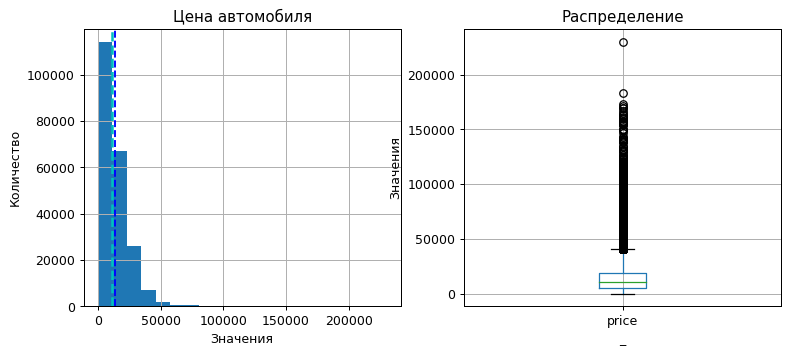

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=90)
df_vin['price'].plot.hist(title='Цена автомобиля', bins=20, ax=ax1, grid=True)
ax1.set_xlabel('Значения')
ax1.set_ylabel('Количество')
ax1.axvline(df_vin['price'].mean(), color='b', linestyle='dashed')
ax1.axvline(df_vin['price'].median(), color='c', linestyle='dashed', linewidth=2)
df_vin['price'].to_frame().boxplot(ax=ax2)
ax2.set_title('Распределение')
ax2.set_ylabel('Значения')
ax2.set_xlabel('_')
plt.show()

Распределение неравномерно, есть одно выболяющееся значение с большой ценой, но онооно не сильно отличается от других больших чисел.Много "выборосов" с большой ценой

In [ ]:
def graf (a):
    df_vin.pivot_table(index=a, values='price', aggfunc='count')\
        .sort_values(by='price')\
        .plot(  y = 'price', kind = 'bar', legend = False)
    plt.ylabel (' ')
    plt.title('Распределение '+a)
    plt.show()

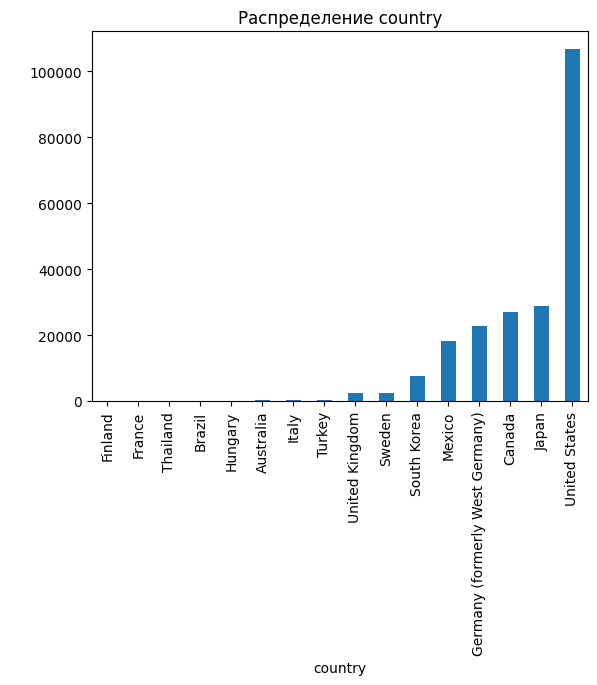

In [ ]:
graf('country')

Большинство машин с США, что соответвует первоначальному занданию распределения именно на рынке американских машиню

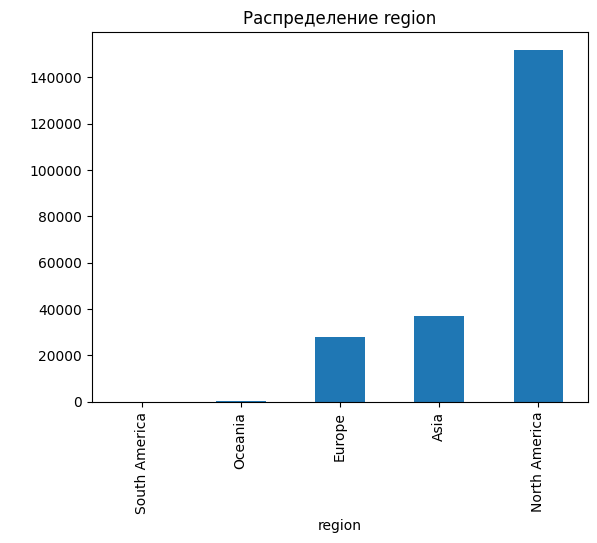

In [ ]:
graf('region')

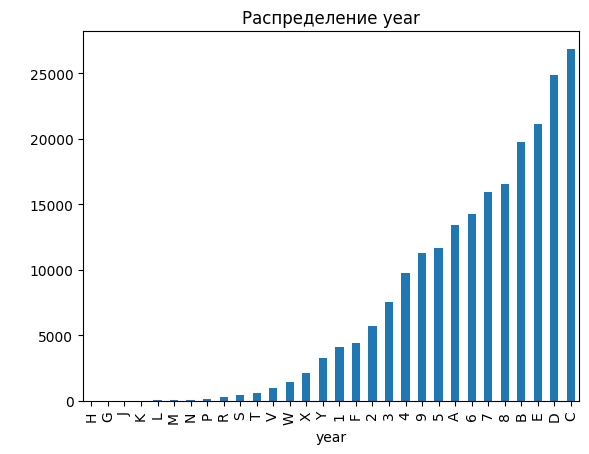

In [ ]:
graf('year')

В основном автомобмли с 2011 по 2014 года

In [ ]:
interval_cols = ['price']

In [ ]:
phik_overview = df_vin.phik_matrix(interval_cols=interval_cols)

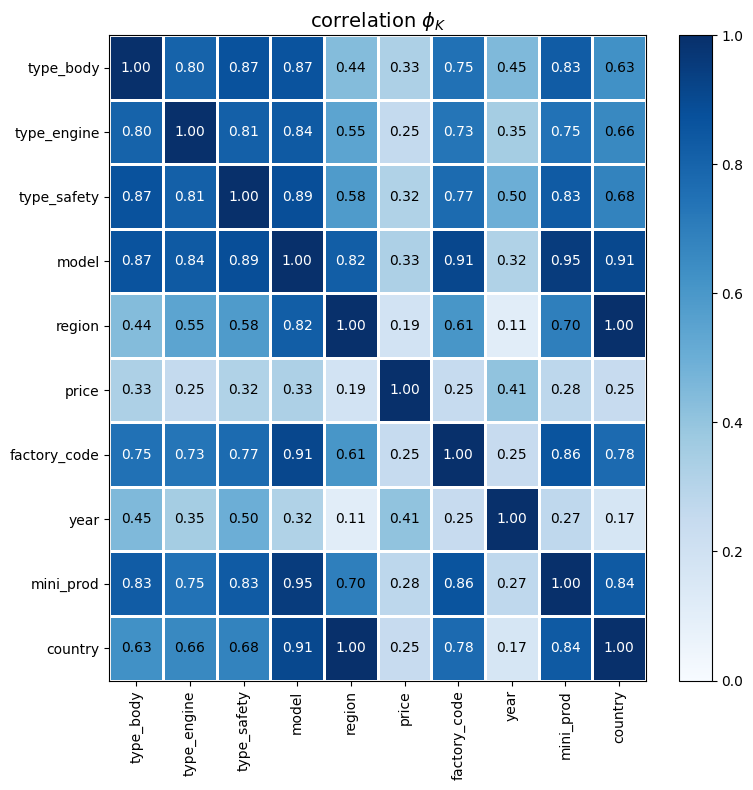

In [ ]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.0,
                        figsize=(8,8))

Полная корреляция между Страной и регионом, что логично

In [ ]:
df_vin = df_vin.drop(['region'], axis=1)

## Обучение моделей

In [ ]:
df_vin.head()

,country,mini_prod,year,factory_code,price,model,type_safety,type_engine,type_body
38,Germany (formerly West Germany),W,6,P,4000,Volkswagen,7,K,E
86,Brazil,W,1,4,2900,Volkswagen,2,D,G
154,Mexico,W,D,M,12000,Volkswagen,7,P,F
185,Germany (formerly West Germany),U,E,N,40500,Audi,A,M,F
206,Germany (formerly West Germany),1,7,D,18000,Audi,7,Y,B


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_vin.drop(['price'], axis=1),
    df_vin['price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

In [ ]:
X_train.shape

(173621, 8)

In [ ]:
X_test.shape

(43406, 8)

In [ ]:
y_test.shape

(43406,)

Для начала, построим Демми-модель

In [ ]:
dummy = DummyRegressor(strategy='mean')

In [ ]:
dummy.fit(X_train,y_train)

DummyRegressor()

In [ ]:
dummy_pred = dummy.predict(X_test)

In [ ]:
print('RMSE на демми-модели:',mean_squared_error(y_test,dummy_pred, squared=False))

RMSE на демми-модели: 11399.88731654831


Бустинг

In [ ]:
ord_pipe = Pipeline(
    [('ord', OrdinalEncoder())]
    )

In [ ]:
cat_columns_lr = X_train.select_dtypes(exclude='number').columns.tolist()

In [ ]:
data_preprocessor_lg = ColumnTransformer(
    [('ord', ord_pipe, cat_columns_lr)
    ],
    remainder='passthrough'
)

In [ ]:
pipe_lgbm = Pipeline([
    ('preprocessor', data_preprocessor_lg),
    ('models', LGBMRegressor(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [ ]:
param_grid = [
    {
         'models': [LGBMRegressor(random_state=RANDOM_STATE, pred_contrib=True)],
         'models__num_leaves': range(659, 660),
         'models__n_estimators': range(340, 341)
    }
]

In [ ]:
search = GridSearchCV(
    pipe_lgbm,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    error_score ='raise'
)
search.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: pred_contrib
[LightGBM] [Warning] Unknown parameter: pred_contrib
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 138896, number of used features: 8
[LightGBM] [Info] Start training from score 13381.906556
[LightGBM] [Warning] Unknown parameter: pred_contrib
[LightGBM] [Warning] Unknown parameter: pred_contrib
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 138897, number of used features: 8
[LightGBM] [Info] Start training from score 13337.184223
[LightGBM] [Warning] Unknown parameter: pred_contrib
[LightGBM] [Warning] Unknown parameter: pred_

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder())]),
                                                                         ['country',
                                                                          'mini_prod',
                                                                          'year',
                                                                          'factory_code',
                                                                          'model',
                                                                          'type_safety',
                                                                          'type_engine',
                                                                          'type_body'])])),
                                       ('models',
                                        LGBMRegressor(class_weight='balanced',
                                                      random_state=42))]),
             param_grid=[{'models': [LGBMRegressor(n_estimators=340,
                                                   num_leaves=659,
                                                   pred_contrib=True,
                                                   random_state=42)],
                          'models__n_estimators': range(340, 341),
                          'models__num_leaves': range(659, 660)}],
             scoring='neg_mean_squared_error')

In [ ]:
search.best_params_

{'models': LGBMRegressor(n_estimators=340, num_leaves=659, pred_contrib=True,
               random_state=42),
 'models__n_estimators': 340,
 'models__num_leaves': 659}

In [ ]:
search.best_score_

-12183055.740847623

In [ ]:
pred = search.predict(X_test)

In [ ]:
best_params = search.best_estimator_

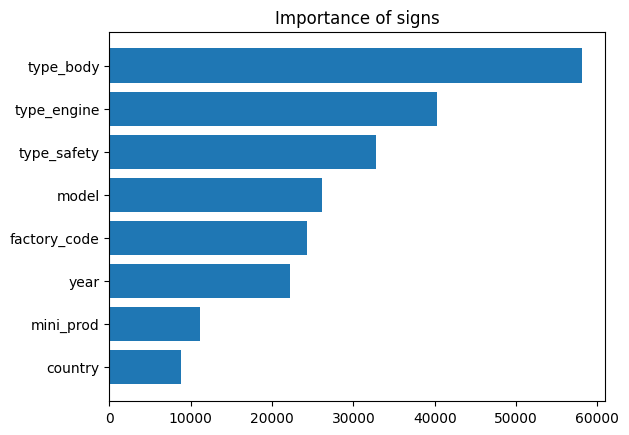

In [ ]:
features = X_train.columns
importance_values = best_params[1].feature_importances_
importance_values.sort()
plt.barh(y=range(len(features)),
       width=importance_values,
           tick_label=features)
plt.title('Importance of signs')
plt.show()

Самыми полезными оказались признаки комплектации автомобилей. Самым бесполезным - страна производителя. При этом страна производства влияет на можель даже больше.

In [ ]:
y_pred = search.predict(X_test)
print('RMSE на тестовой выборке:',mean_squared_error(y_test, y_pred, squared=False))
print('MAE на тестовой выборке:',mean_absolute_error(y_test, y_pred))
print('Max Error на тестовой выборке:',max_error(y_test, y_pred))
print('Explained Variance Score на тестовой выборке:',explained_variance_score(y_test, y_pred))

RMSE на тестовой выборке: 3460.705525281071
MAE на тестовой выборке: 2357.585465544812
Max Error на тестовой выборке: 94430.07555673164
Explained Variance Score на тестовой выборке: 0.9078443315855627


Модель не идеальна, но метрика RMSE в три раза лучше, чем на Демми-модели. Остальные метрика показывают также нормальный результат.

In [ ]:
pred_df = pd.DataFrame(data=y_pred, columns=['pred'])
y_test = y_test.to_frame()

In [ ]:
df_total = X_test.join(y_test)

In [ ]:
df_total = df_total.reset_index(drop=True)
df_total = df_total.join(pred_df)
df_total.head()

,country,mini_prod,year,factory_code,model,type_safety,type_engine,type_body,price,pred
0,United Kingdom,J,9,H,Jaguar,other,other,other,14500,15460.287468
1,Canada,3,C,W,Toyota,D,F,B,16100,14384.223646
2,United States,M,D,E,Ford,J,5,U,30000,30720.223588
3,Japan,1,D,1,Mazda,other,P,V,11100,12324.416856
4,Japan,D,D,5,Toyota,D,N,K,12700,14390.282362


In [ ]:
h = df_total['model'].unique()
df_total['difference'] = abs(df_total['pred']-df_total['price'])

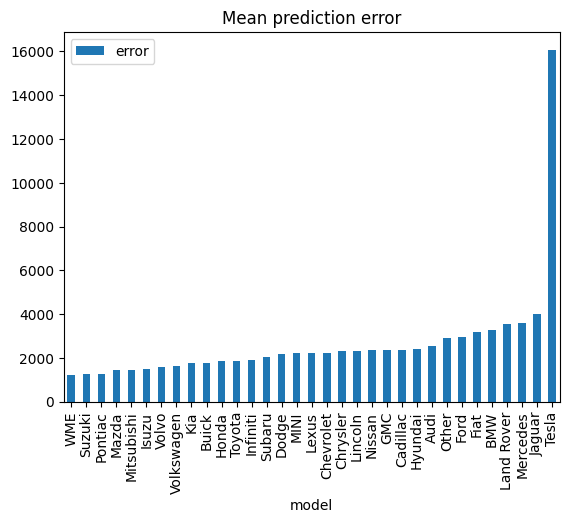

In [ ]:
itog = pd.DataFrame(columns= ['model', 'error'])
for i in range(len(h)):
  itog.loc[i] = [h[i],df_total[df_total['model']==h[i]]['difference'].mean()]
itog.sort_values(by='error').plot(x='model', y='error', kind='bar')
plt.title('Mean prediction error')
plt.show()

Ошибка предсказаний в основном между 1000 и 4000. Сильная ошибка у Tesla, это связано с тем, что данная модель очень плохо представлена в датафрейме.

In [ ]:
def one_vin(kod):
    pattern_new = r'''
       (?P<country>.{2})
       (?P<mini_prod>.{1})
       (?P<number_4>.{1})
       (?P<number_5>.{1})
       (?P<number_6>.{1})
       (?P<number_7>.{1})
       (?P<number_8>.{1})
       (?P<control>.{1})
       (?P<year>.{1})
       (?P<factory_code>.{1})
       (?P<serial_namber>.{3}\d{3})
      '''
    df= pd.DataFrame.from_dict([(x.groupdict()) \
                        for x in re.compile(pattern_new, re.X).finditer(kod)])
    df['VMI']= df['country']+df['mini_prod']
    country_dict = {}
    for k in range(len(country_df)):
        if df['country'][0] in country_df['cipher'][k]:
            country_dict['country'] = country_df['country'][k]
    s = [*country_dict.values()][0]
    if s in df_vin['country'].unique():
        print('Страна производитель: ', s)
        df['country'] = s
    else:
        print('Страна производитель: ', s)
        df['country'] = 'United States'
    model_dict = {}
    for k in range(len(model_df)):
        if df['VMI'][0] in model_df['WMI'][k]:
            model_dict['country'] = model_df['marka'][k]
    s = [*model_dict.values()][0]
    if s in df_vin['model'].unique():
        print('Model: ', s)
        df['model'] = s
    else:
        print('Страна производитель: ', s)
        df['model'] = 'Other'
    year = (symbols.replace('0','').replace('Z','').replace('U','')*2)[14:45]
    year_dict,n  = {},1994
    for i in year:
        year_dict[i] = n
        n+=1
    print('Год автомобиля', year_dict[df['year'][0]])
    df['type_safety'] = df['model'].apply(safety)
    df['type_engine'] = df['model'].apply(engine)
    df['type_body'] = df['model'].apply(body)
    a = ['type_safety','type_engine', 'type_body']
    for i in a:
        if df[i][0] == 4:
            df[i] = df['number_4']
        elif df[i][0] == 5:
            df[i] = df['number_5']
        elif df[i][0] == 6:
            df[i] = df['number_6']
        elif df[i][0] == 7:
            df[i] = df['number_7']
        elif df[i][0] == 8:
            df[i] = df['number_8']
        else:
            df[i] = 'other'
    df = df.drop(['number_4', 'number_5', 'number_6',
            'control','number_7','number_8', 'serial_namber', 'VMI'], axis=1)
    pred = search.predict(df)
    print('Примерная стоимость автомобиля:', round(*pred))

## Выводы

В данном проекте была создана модель машинного обучения, предсказывающая стоимость автомобилей исходя из их Вин-кодов. Модель предсказывает результата в 3 раза лучше, чем демми-можель, и имеет среднююю ошибку предсказания около 3 тыс. Исходя из изученных данных наже создана функция, которая принимает значение vin-кода автомобиля и выдает всю найденную информацию.

In [ ]:
one_vin('Z94CB41AACR123456')

Страна производитель:  Russia
Model:  Hyundai
Год автомобиля 2012
Примерная стоимость автомобиля: 18598


In [ ]:
one_vin ('JHMCM56557C404453')

Страна производитель:  Japan
Model:  Honda
Год автомобиля 2007
Примерная стоимость автомобиля: 6225


Созданная модель может быть доработана более детальной информацией по каждой марке автомобилей и увеличеснием объема обучающей выборки